In [1]:
import torch as th
import torchvision as tv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
ds_train = tv.datasets.MNIST(root='.', download=True)
ds_test = tv.datasets.MNIST(root='.', train=False, download=True)

In [3]:
np_x_train = np.array([np.array(x[0]) for x in ds_train])
np_x_test = np.array([np.array(x[0]) for x in ds_test])
np_x_train = np_x_train / 255.
np_x_test = np_x_test / 255.

# re-prep the datasets
ds_train = th.utils.data.TensorDataset(th.tensor(np_x_train.reshape(-1,28*28), device=th.device('cuda'), dtype=th.float32))
ds_test = th.utils.data.TensorDataset(th.tensor(np_x_test.reshape(-1,28*28), device=th.device('cuda'), dtype=th.float32))

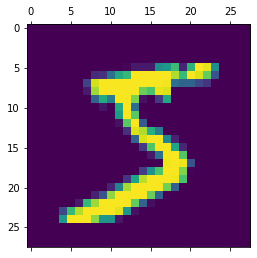

In [4]:
BATCH_SIZE = 1024
dl = th.utils.data.DataLoader(ds_train, batch_size=BATCH_SIZE)
dl_test = th.utils.data.DataLoader(ds_test, batch_size=16)
for x, in dl:
    break
plt.matshow(x[0].cpu().numpy().reshape(28,28))
x.shape
for th_x_test, in dl_test:
    break

In [5]:
def th_eval_vae(model, th_sample):
    model.eval()
    with th.no_grad():
        th_yh, _, _ = model(th_sample)
    plt.figure()
    plt.subplot(121)    
    gold_grid = tv.utils.make_grid(th_sample.view(16,1,28,28), nrow=4)
    np_gold_img = gold_grid.cpu().numpy().transpose(1,2,0)    
    plt.imshow(np_gold_img)
    
    plt.subplot(122)    
    pred_grid = tv.utils.make_grid(th_yh.view(16,1,28,28), nrow=4)
    np_pred_img = pred_grid.cpu().numpy().transpose(1,2,0)    
    plt.imshow(np_pred_img)
    plt.show()
    model.train()

***
$\mathbf{\text{KL Reminder}}$<br>
***

$$KL(D_1,D_2) = \log (\frac{s_2}{s_1}) + \frac {1}{2} \frac {s_1^2 +(m_1 - m_2)^2} {s_2^2} - \frac{1}{2}$$


      if target is N(0,1) then s2 = 1 m2 = 0 then
       KL_Loss = 0 - log(s1) + 0.5 * (s1**2 + m1**2) - 0.5
       KL_loss = -0.5 * ( 2*log(s1) - s1**2 - m1**2 + 1)
       =>
       KL_loss = -0.5 * (log(v1) - v1 - m1**2 + 1)
         in this case z = rnd * v1 + m1
       or (using log_of_v1)
       KL_loss = -0.5 * (v1_ln - e**v1_ln - m1**2 + 1)
         in this case the z = rnd * e**(v1_ln/2) + m1
         
       std = sqrt(var)
       var = e^log(var)
       std = sqrt(e^log(var))
       std = e^(log(var^0.5)) = e^(0.5 * log(var))

In [7]:
class SimpleVAE(th.nn.Module):
    def __init__(self, inp_size, encoding=[512, 256], embedding_size=32):
        super().__init__()
        self.enc_layers = th.nn.ModuleList()
        prev_units = inp_size
        for units in encoding:
            self.enc_layers.append(th.nn.Linear(prev_units, units))
            self.enc_layers.append(th.nn.ReLU())
            prev_units = units
        
        # Here the stuff gets a bit more complicated than `self.embedding = th.nn.Linear(prev_units, embedding_size)`
        self.emb_mean = th.nn.Linear(prev_units, embedding_size)
        self.emb_log_var = th.nn.Linear(prev_units, embedding_size)

        prev_units = embedding_size
        self.dec_layers = th.nn.ModuleList()
        for units in reversed(encoding):
            self.dec_layers.append(th.nn.Linear(prev_units, units))
            prev_units = units
            self.dec_layers.append(th.nn.ReLU())
        
        self.readout = th.nn.Linear(prev_units, inp_size)
        return
        
    def encoder(self, inputs):
        if len(inputs.shape) > 2: 
            # do NOT use this approach in real-life models.
            # instead use pre-processing reshaping (via tv pre-proc pipeline or manual)
            th_x = inputs.view(inputs.shape[0], -1)
        else:
            th_x = inputs
            
        for layer in self.enc_layers:
            th_x = layer(th_x)
        th_mean = self.emb_mean(th_x)
        th_log_var = self.emb_log_var(th_x)
        return th_mean, th_log_var
    
    def decoder(self, inputs):
        th_x = inputs
        for layer in self.dec_layers:
            th_x = layer(th_x)
        return self.readout(th_x)
    
    def forward(self, inputs):
        th_x_mean, th_x_log_var = self.encoder(inputs)
        th_x_rnd = th.randn_like(th_x_mean).to(th_x_mean.device)
        th_x_std = th.exp(0.5 * th_x_log_var)
        th_x = th_x_rnd * th_x_std + th_x_mean 
        th_x = self.decoder(th_x)
        return th_x, th_x_mean, th_x_log_var
        
model = SimpleVAE(28*28).cuda()
model        
        

SimpleVAE(
  (enc_layers): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
  )
  (emb_mean): Linear(in_features=256, out_features=32, bias=True)
  (emb_log_var): Linear(in_features=256, out_features=32, bias=True)
  (dec_layers): ModuleList(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
  )
  (readout): Linear(in_features=512, out_features=784, bias=True)
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


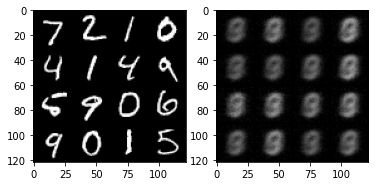

33660.26 385.36194


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


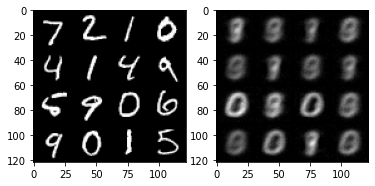

31076.826 1045.771


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


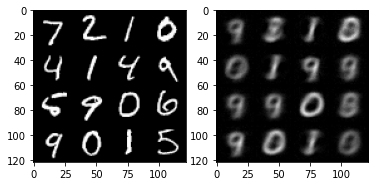

29347.28 1665.558


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


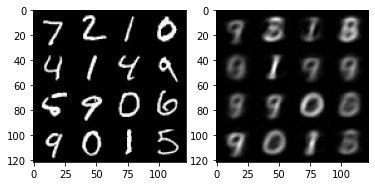

27592.688 2097.3872


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


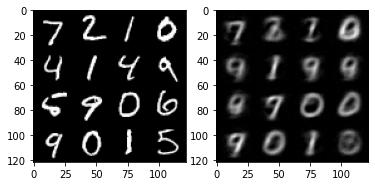

23205.21 3318.8508


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


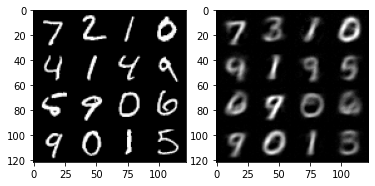

21162.936 3790.0803


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


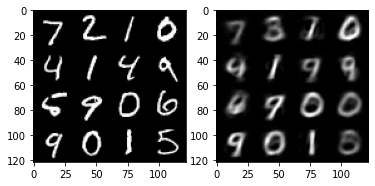

19495.863 4020.1382


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


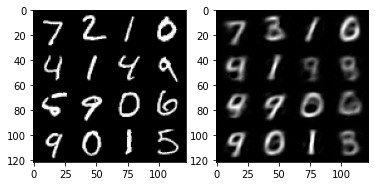

18229.01 4324.7603


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


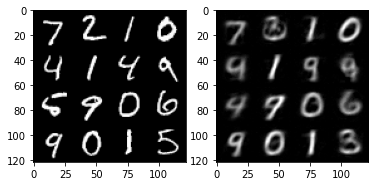

17516.236 4392.87


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


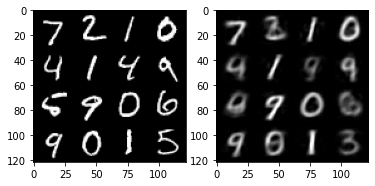

16670.441 4707.064


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


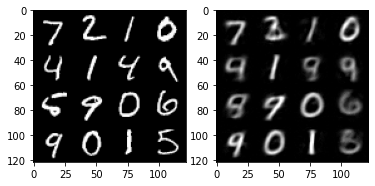

16466.281 4684.667


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


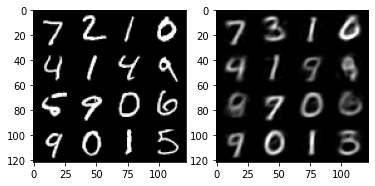

15976.257 4818.4814


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


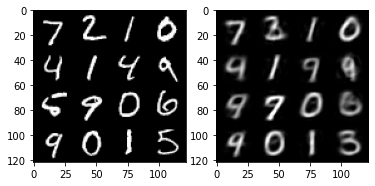

15620.986 4838.039


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


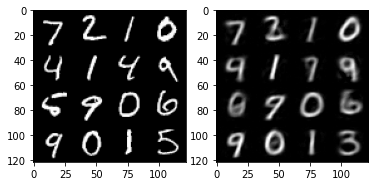

15506.342 4839.5957


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


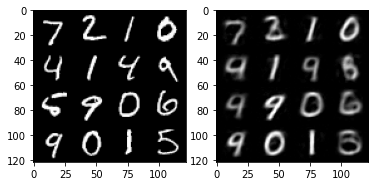

15245.742 4957.1523


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


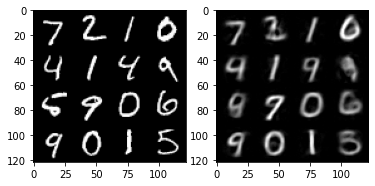

14980.607 4958.9043


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


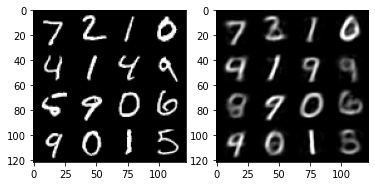

14712.273 5017.354


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


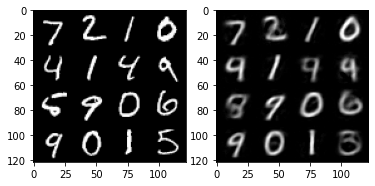

14558.611 5150.626


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


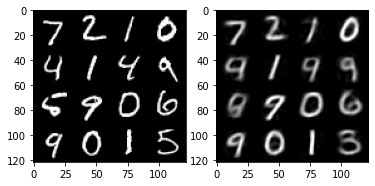

14311.053 5216.945


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


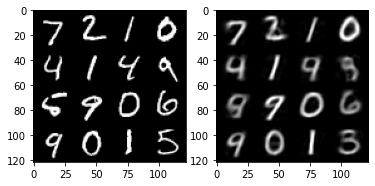

14308.826 5171.0303


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


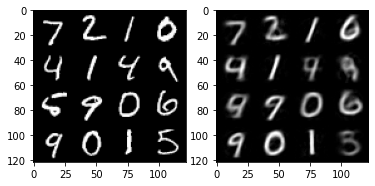

14141.612 5158.735


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


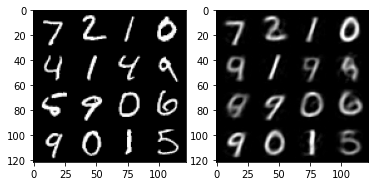

14013.61 5145.6543


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


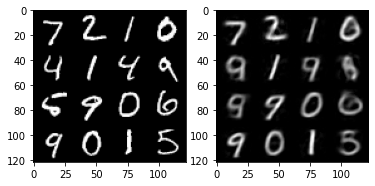

13932.05 5218.87


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


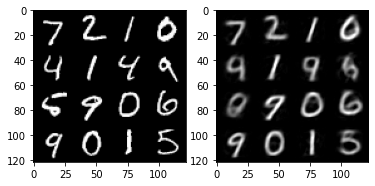

13989.904 5188.212


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


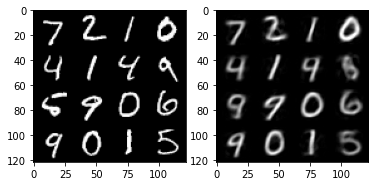

13714.568 5268.97


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


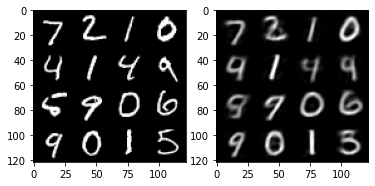

13707.067 5298.019


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


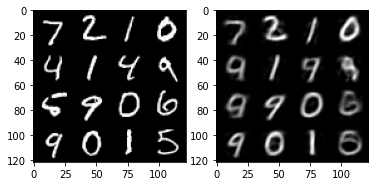

13548.16 5343.003


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


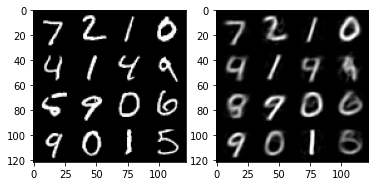

13358.576 5376.542


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


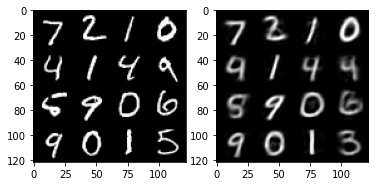

13281.104 5381.4453


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


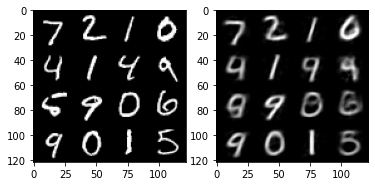

13282.488 5403.611


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


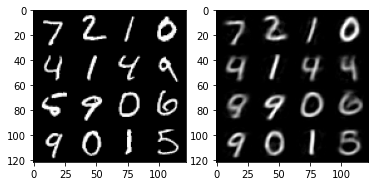

13278.682 5346.7427


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


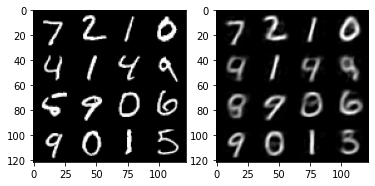

13161.521 5443.0195


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


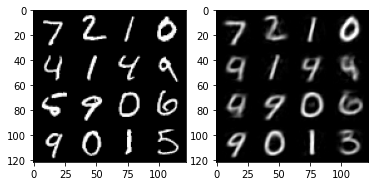

13161.888 5488.724


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


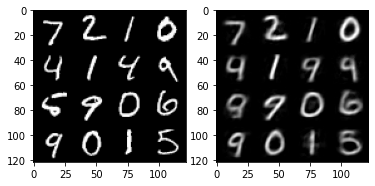

13010.5205 5474.3423


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


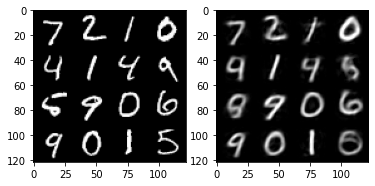

12909.066 5496.0566


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


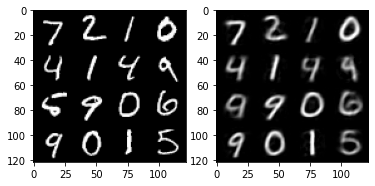

12817.244 5559.524


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


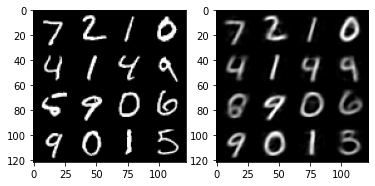

12932.353 5518.817


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


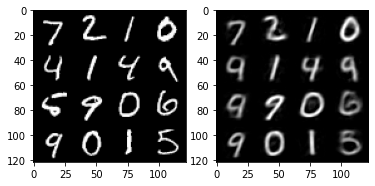

12808.152 5476.0366


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


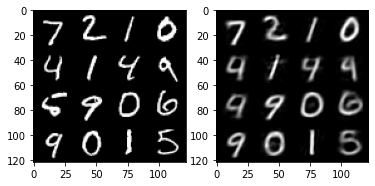

12843.571 5440.2217


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


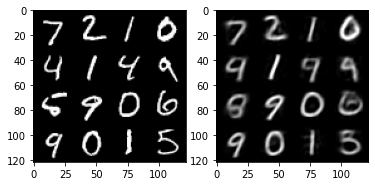

12790.705 5501.45


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


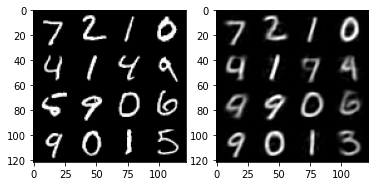

12770.863 5485.3438


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


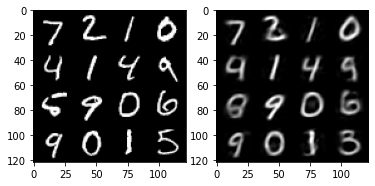

12624.961 5590.0815


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


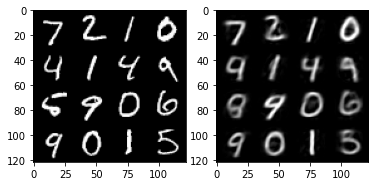

12631.083 5659.491


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


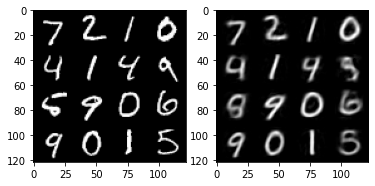

12679.225 5570.37


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


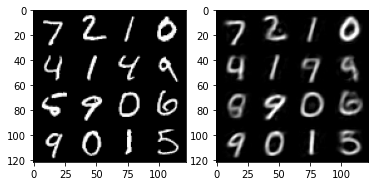

12543.247 5606.6577


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


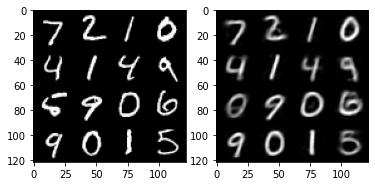

12462.497 5693.0996


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


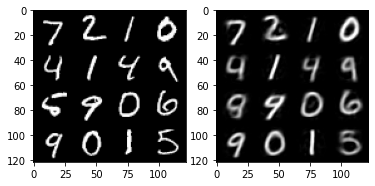

12410.431 5649.4136


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


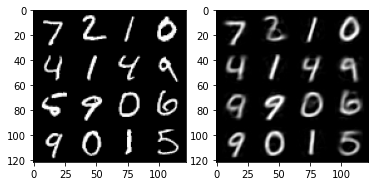

12435.604 5598.994


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


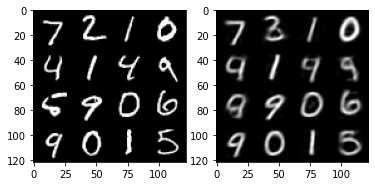

12497.203 5573.8594


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


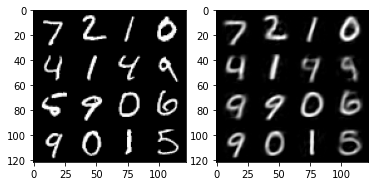

12331.607 5684.5625


In [19]:
loss_fn_recon = th.nn.MSELoss(reduction='sum') # default is average (reduction='sum')
loss_fn_kl = th.nn.KLDivLoss()
model = SimpleVAE(28*28).cuda()
opt = th.optim.Adam(params=model.parameters(), lr=0.001)
EPOCHS = 50
th_l1 = next(model.parameters())
DEBUG = False
for epoch in range(EPOCHS):
    cnt = 0
    for th_x_batch,  in dl:
        opt.zero_grad()
        cnt += 1
        
        th_y_pred, th_mean, th_log_var = model(th_x_batch)
        
        th_rec_loss = loss_fn_recon(input=th_y_pred, target=th_x_batch.view(th_x_batch.shape[0], -1))

        th_kl_loss = -0.5 * th.sum(th_log_var - th.exp(th_log_var) - th.pow(th_mean, 2) + 1)  
        
        if DEBUG:
            print(th_rec_loss, th_kl_loss)
            if cnt > 5:
                break
        
        th_loss = th_rec_loss + th_kl_loss
        
        th_loss.backward()
        opt.step()
    if DEBUG:
        break
    th_eval_vae(model, th_sample=th_x_test)
    print(th_rec_loss.detach().cpu().numpy(), th_kl_loss.detach().cpu().numpy())

In [15]:
th_rec_loss

tensor(95796.2188, device='cuda:0', grad_fn=<MseLossBackward0>)

In [16]:
th_kl_loss

tensor(63.8233, device='cuda:0', grad_fn=<MulBackward0>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


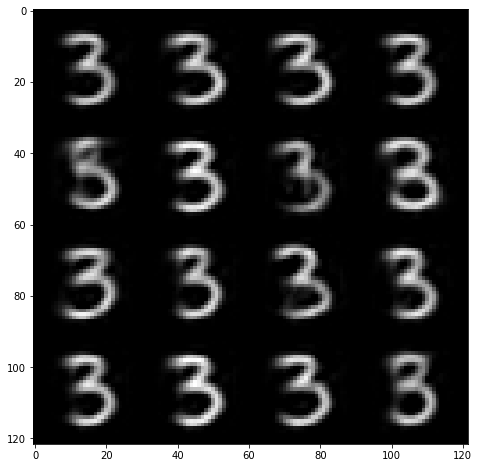

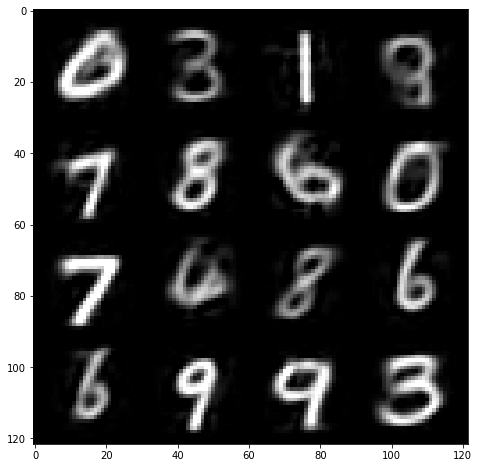

In [24]:
def th_eval_generate(model, ds, idx=None):
    model.eval()
    with th.no_grad():
        dev = next(model.parameters()).device
        th_noise = th.randn(16, 32).to(dev)
        if idx is not None:
            if True:
                th_noise_scale = th.tensor(np.random.randint(1,3, size=(16,1)), device=dev)        
                th_noise = th_noise * th_noise_scale
            th_yh_mean, th_yh_log_var = model.encoder(ds[idx][0].unsqueeze(0))
            th_embeds = th_noise * th.exp(0.5 * th_yh_log_var) + th_yh_mean
        else:
            th_embeds = th_noise
            
        th_imgs = model.decoder(th_embeds)

        pred_grid = tv.utils.make_grid(th_imgs.view(16,1,28,28), nrow=4)
        np_pred_img = pred_grid.cpu().numpy().transpose(1,2,0)
        plt.figure(figsize=(13,8))
        plt.imshow(np_pred_img)
th_eval_generate(model, ds=ds_test, idx=5000)
th_eval_generate(model, ds=ds_test)